### Pre-requisite steps to run this notebook
1. Run the candidate_label_creation, candidate_filter, and HAS_entity_embeddings notebooks first (these have their own pre-reqs). We will use files that were created by those notebooks in this notebook.

In [403]:
import os
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from utility import run_command
from utility import rename_cols_and_overwrite_id
from label_discretization import discretize_labels
from gensim.models import KeyedVectors

### Parameters
**REQUIRED**  
**type_to_profile**: The type that we will create a label set for, and therefore be able to create entity profiles for. This should be a string denoting a Q-node. e.g. if we want to create profiles for beers, we would set type_to_profile="Q44" (Q44=beer).  
**work_dir**: path to work dir that was specified in the candidate_label_creation, candidate_filter, and HAS_embeddings notebooks. We will utilize files that were saved by those previous notebooks, and also save files created by this notebook here.  
**item_file**: file path for the file that contains entity to entity relationships (e.g. wikibase-item)  
**time_file**: file path for the file that contains entity to time-type values  
**quantity_file**: file path for the file that contains entity to quantity-type values  
**label_file**: file path for the file that contains wikidata labels  
**store_dir**: path to folder containing the sqlite3.db file that we will use for our queries. We will reuse an existing file if there is one in this folder. Otherwise we will create a new one.

**OPTIONAL**  
**In-progress... this is currently not used.**  
*string_file*: file path for the file that contains entity to string-type values  

In [4]:
data_dir = "../../Q44/data" # my data files are all in the same directory, so I'll reuse this path prefix

# **REQUIRED**
type_to_profile = "Q44"
work_dir = "../../Q44/profiler_work"
item_file = "{}/Q44.part.wikibase-item.tsv".format(data_dir)
time_file = "{}/Q44.part.time.tsv".format(data_dir)
quantity_file = "{}/Q44.part.quantity.tsv".format(data_dir)
label_file = "{}/Q44.label.en.tsv".format(data_dir)
store_dir = "../../Q44"

# **optional**
string_file = None #"{}/Q44.part.string.tsv".format(data_dir)

### Process parameters and set up variables / file names

In [176]:
# Ensure paths are absolute
item_file = os.path.abspath(item_file)
time_file = os.path.abspath(time_file)
quantity_file = os.path.abspath(quantity_file)
label_file = os.path.abspath(label_file)
work_dir = os.path.abspath(work_dir)
store_dir = os.path.abspath(store_dir)
if string_file:
    string_file = os.path.abspath(string_file)
    
# Create directories
output_dir = "{}/final_label_sets/{}".format(work_dir, type_to_profile)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
label_set_work_dir = "{}/work".format(output_dir)
if not os.path.exists(label_set_work_dir):
    os.makedirs(label_set_work_dir)
label_set_final_dir = "{}/final".format(output_dir)
if not os.path.exists(label_set_final_dir):
    os.makedirs(label_set_final_dir)
    

    
# adding some environment variables we'll be using frequently
os.environ['ITEM_FILE'] = item_file
os.environ['TIME_FILE'] = time_file
os.environ['QUANTITY_FILE'] = quantity_file
os.environ['LABEL_FILE'] = label_file
os.environ['STORE'] = "{}/wikidata.sqlite3.db".format(store_dir)
os.environ['FILTERED_LABELS'] = "{}/candidate_filter".format(work_dir)
os.environ['LABEL_CREATION_DIR'] = "{}/label_creation".format(work_dir)
os.environ['TYPE'] = type_to_profile
os.environ['WORK'] = label_set_work_dir
os.environ['OUT'] = label_set_final_dir
os.environ['kgtk'] = "kgtk" # Need to do this for kgtk to be recognized as a command when passing it through a subprocess call

## 1. Get labels that abstract entities of the type we want to profile and find the entities that match each of those labels

**this could possibly be a separate notebook or just code moved out of notebook.**

**Actually we could do this in earlier steps along the way - like in label creation... For scalability, if we did this we might need to move the type_to_profile decision to there so we don't enumerate all labels and their entities (this would blow up when we get to RALs).** 

**since we didn't keep quantities and times separate for ravls and rails, the final label set won't be able to disambiguate whether the value for these is a time or quantity - this actually isn't much of a problem since the property will be able to disambiguate time versus quantity, however it means that we'll have to look in a concatenated quantities/times file when creating a profile for an entity.**

We will later choose from these labels to form the final label set, and we will do this based off of several formulas that take into account the entities that match each label.

Also, we need each label to have a unique identifier (again this is something that we could have done along the way in earlier notebooks - would simplify some queries). We'll add a column for this here as well.

### 1.1 RELs

In [177]:
!kgtk query -i $FILTERED_LABELS/candidate_labels_rel_item_filtered.tsv \
-i $ITEM_FILE -i $LABEL_CREATION_DIR/type_mapping.tsv \
-o $WORK/candidate_RELs_and_their_entities.tsv --graph-cache $STORE \
--match 'filtered: (type:`'"$TYPE"'`)-[l1 {label:p, prop_label:p_lab, id:label_id}]->(val), `'"$ITEM_FILE"'`: (e1)-[l2 {label:p}]->(val), type: (e1)-[]->(type)' \
--return 'distinct type as node1, p as label, p_lab as prop_label, val as node2, printf("REL-%s", label_id) as label_id, e1 as entity, "_" as id' \
--order-by 'type, label, val, e1'

In [178]:
!kgtk add-id -i $WORK/candidate_RELs_and_their_entities.tsv -o $WORK/candidate_RELs_and_their_entities.tsv --overwrite-id

In [335]:
labels_df = pd.read_csv("{}/candidate_RELs_and_their_entities.tsv".format(os.environ["WORK"]), delimiter = '\t')
print("number of distinct labels: {}".format(len(labels_df.label_id.unique())))
print("number of rows (labels can have multiple matching entities): {}".format(labels_df.shape[0]))
display(labels_df.loc[:10].fillna(""))

number of distinct labels: 36
number of rows (labels can have multiple matching entities): 53


,node1,label,prop_label,node2,label_id,entity,id
0,Q44,P1056,'product or material produced'@en,Q93552342,REL-E22327,Q12877510,E1
1,Q44,P1056,'product or material produced'@en,Q93557205,REL-E22328,Q12877510,E2
2,Q44,P1056,'product or material produced'@en,Q93558270,REL-E22329,Q12877510,E3
3,Q44,P1056,'product or material produced'@en,Q93559285,REL-E22330,Q12877510,E4
4,Q44,P1056,'product or material produced'@en,Q93560567,REL-E22331,Q12877510,E5
5,Q44,P1056,'product or material produced'@en,Q93560976,REL-E22332,Q12877510,E6
6,Q44,P1056,'product or material produced'@en,Q97412285,REL-E22333,Q12877510,E7
7,Q44,P112,'founded by'@en,Q90449270,REL-E22334,Q12877510,E8
8,Q44,P127,'owned by'@en,Q12877510,REL-E38780,Q93552342,E9
9,Q44,P127,'owned by'@en,Q12877510,REL-E38780,Q93557205,E10


### 1.2 AVLs - quantities

In [194]:
!kgtk query -i $FILTERED_LABELS/candidate_labels_avl_quantity_filtered.tsv \
-i $QUANTITY_FILE -i $LABEL_CREATION_DIR/type_mapping.tsv \
-o $WORK/candidate_quantity_AVLs_and_their_entities.tsv --graph-cache $STORE \
--match 'filtered: (type:`'"$TYPE"'`)-[l1 {label:p, prop_label:p_lab, id:label_id, si_units:label_si, wd_units:label_wd}]->(label_quantity_num), `'"$QUANTITY_FILE"'`: (e)-[l2 {label:p}]->(val), type: (e)-[]->(type)' \
--return 'distinct type as node1, p as label, p_lab as prop_label, label_quantity_num as node2, label_si as si_units, label_wd as wd_units, printf("AVL-quantity-%s", label_id) as label_id, e as entity, "_" as id' \
--where 'kgtk_quantity_number(val)=label_quantity_num AND ( (kgtk_quantity_si_units(val) is null AND label_si="") OR (kgtk_quantity_si_units(val)=label_si) ) AND ( (kgtk_quantity_wd_units(val) is null AND label_wd="") OR (kgtk_quantity_wd_units(val)=label_wd) )' \
--order-by 'type, label, node2, si_units, wd_units, e'

In [195]:
!kgtk add-id -i $WORK/candidate_quantity_AVLs_and_their_entities.tsv -o $WORK/candidate_quantity_AVLs_and_their_entities.tsv --overwrite-id

In [334]:
labels_df = pd.read_csv("{}/candidate_quantity_AVLs_and_their_entities.tsv".format(os.environ["WORK"]), delimiter = '\t')
print("number of distinct labels: {}".format(len(labels_df.label_id.unique())))
print("number of rows (labels can have multiple matching entities): {}".format(labels_df.shape[0]))
display(labels_df.loc[:10].fillna(""))


number of distinct labels: 7
number of rows (labels can have multiple matching entities): 7


,node1,label,prop_label,node2,si_units,wd_units,label_id,entity,id
0,Q44,P2226,'market capitalization'@en,3896025.7,,,AVL-quantity-E51037,Q12877510,E1
1,Q44,P2665,'alcohol by volume'@en,0.4,,Q2080811,AVL-quantity-E51038,Q97412285,E2
2,Q44,P2665,'alcohol by volume'@en,5.4,,Q2080811,AVL-quantity-E51040,Q93559285,E3
3,Q44,P2665,'alcohol by volume'@en,5.5,,Q2080811,AVL-quantity-E51041,Q93560567,E4
4,Q44,P2665,'alcohol by volume'@en,5.8,,Q2080811,AVL-quantity-E51042,Q93557205,E5
5,Q44,P2665,'alcohol by volume'@en,6.3,,Q2080811,AVL-quantity-E51043,Q93558270,E6
6,Q44,P6088,'beer bitterness'@en,29.5,,,AVL-quantity-E51046,Q93557205,E7


### 1.3 AVLs - times

In [197]:
!kgtk query -i $FILTERED_LABELS/candidate_labels_avl_time.year_filtered.tsv \
-i $TIME_FILE -i $LABEL_CREATION_DIR/type_mapping.tsv \
-o $WORK/candidate_time.year_AVLs_and_their_entities.tsv --graph-cache $STORE \
--match 'filtered: (type:`'"$TYPE"'`)-[l1 {label:p, prop_label:p_lab, id:label_id}]->(label_year), `'"$TIME_FILE"'`: (e)-[l2 {label:p}]->(val), type: (e)-[]->(type)' \
--return 'distinct type as node1, p as label, p_lab as prop_label, label_year as node2, printf("AVL-time.year-%s", label_id) as label_id, e as entity, "_" as id' \
--where 'kgtk_date_year(val)=label_year' \
--order-by 'type, label, node2, e'

In [198]:
!kgtk add-id -i $WORK/candidate_time.year_AVLs_and_their_entities.tsv -o $WORK/candidate_time.year_AVLs_and_their_entities.tsv --overwrite-id

In [333]:
labels_df = pd.read_csv("{}/candidate_time.year_AVLs_and_their_entities.tsv".format(os.environ["WORK"]), delimiter = '\t')
print("number of distinct labels: {}".format(len(labels_df.label_id.unique())))
print("number of rows (labels can have multiple matching entities): {}".format(labels_df.shape[0]))
display(labels_df.loc[:10].fillna(""))

number of distinct labels: 7
number of rows (labels can have multiple matching entities): 7


,node1,label,prop_label,node2,label_id,entity,id
0,Q44,P571,'inception'@en,1996,AVL-time.year-E321,Q12877510,E1
1,Q44,P571,'inception'@en,1998,AVL-time.year-E322,Q93552342,E2
2,Q44,P571,'inception'@en,2001,AVL-time.year-E323,Q93557205,E3
3,Q44,P571,'inception'@en,2003,AVL-time.year-E324,Q93559285,E4
4,Q44,P571,'inception'@en,2013,AVL-time.year-E325,Q93558270,E5
5,Q44,P571,'inception'@en,2017,AVL-time.year-E326,Q93560567,E6
6,Q44,P571,'inception'@en,2020,AVL-time.year-E327,Q97412285,E7


### 1.4 AILs - quantities

In [206]:
!kgtk query -i $FILTERED_LABELS/candidate_labels_ail_quantity_filtered.tsv \
-i $QUANTITY_FILE -i $LABEL_CREATION_DIR/type_mapping.tsv \
-o $WORK/candidate_quantity_AILs_and_their_entities.tsv --graph-cache $STORE \
--match 'filtered: (type:`'"$TYPE"'`)-[l1 {label:p, prop_label:p_lab, id:label_id, upper_bound:ub, si_units:label_si, wd_units:label_wd}]->(lb), `'"$QUANTITY_FILE"'`: (e)-[l2 {label:p}]->(val), type: (e)-[]->(type)' \
--return 'distinct type as node1, p as label, p_lab as prop_label, lb as node2, ub as upper_bound, label_si as si_units, label_wd as wd_units, printf("AIL-quantity-%s", label_id) as label_id, e as entity, "_" as id' \
--where '(not lb OR kgtk_quantity_number(val) >= kgtk_quantity_number(lb)) AND (not ub OR kgtk_quantity_number(ub) >= kgtk_quantity_number(val)) AND ( (kgtk_quantity_si_units(val) is null AND label_si="") OR (kgtk_quantity_si_units(val)=label_si) ) AND ( (kgtk_quantity_wd_units(val) is null AND label_wd="") OR (kgtk_quantity_wd_units(val)=label_wd) )' \
--order-by 'type, label, node2, si_units, wd_units, e'


In [207]:
!kgtk add-id -i $WORK/candidate_quantity_AILs_and_their_entities.tsv -o $WORK/candidate_quantity_AILs_and_their_entities.tsv --overwrite-id

In [332]:
labels_df = pd.read_csv("{}/candidate_quantity_AILs_and_their_entities.tsv".format(os.environ["WORK"]), delimiter = '\t')
print("number of distinct labels: {}".format(len(labels_df.label_id.unique())))
print("number of rows (labels can have multiple matching entities): {}".format(labels_df.shape[0]))
display(labels_df.loc[:10].fillna(""))

number of distinct labels: 6
number of rows (labels can have multiple matching entities): 12


,node1,label,prop_label,node2,upper_bound,si_units,wd_units,label_id,entity,id
0,Q44,P2226,'market capitalization'@en,,,,,AIL-quantity-E401,Q12877510,E1
1,Q44,P2665,'alcohol by volume'@en,,2.7,,Q2080811,AIL-quantity-E402,Q97412285,E2
2,Q44,P2665,'alcohol by volume'@en,2.7,,,Q2080811,AIL-quantity-E1254,Q93552342,E3
3,Q44,P2665,'alcohol by volume'@en,2.7,,,Q2080811,AIL-quantity-E1254,Q93557205,E4
4,Q44,P2665,'alcohol by volume'@en,2.7,,,Q2080811,AIL-quantity-E1254,Q93558270,E5
5,Q44,P2665,'alcohol by volume'@en,2.7,,,Q2080811,AIL-quantity-E1254,Q93559285,E6
6,Q44,P2665,'alcohol by volume'@en,2.7,,,Q2080811,AIL-quantity-E1254,Q93560567,E7
7,Q44,P6088,'beer bitterness'@en,,17.5,,,AIL-quantity-E403,Q93559285,E8
8,Q44,P6088,'beer bitterness'@en,17.5,23,,,AIL-quantity-E722,Q93552342,E9
9,Q44,P6088,'beer bitterness'@en,17.5,23,,,AIL-quantity-E722,Q93558270,E10


### 1.5 AILs - times

In [171]:
!kgtk query -i $FILTERED_LABELS/candidate_labels_ail_time.year_filtered.tsv \
-i $TIME_FILE -i $LABEL_CREATION_DIR/type_mapping.tsv \
-o $WORK/candidate_time.year_AILs_and_their_entities.tsv --graph-cache $STORE \
--match 'filtered: (type:`'"$TYPE"'`)-[l1 {label:p, prop_label:p_lab, id:label_id, upper_bound:ub}]->(lb), `'"$TIME_FILE"'`: (e)-[l2 {label:p}]->(val), type: (e)-[]->(type)' \
--return 'distinct type as node1, p as label, p_lab as prop_label, lb as node2, ub as upper_bound, printf("AIL-time.year-%s", label_id) as label_id, e as entity, "_" as id' \
--where '(not lb OR kgtk_date_year(val) >= kgtk_quantity_number(lb)) AND (not ub OR kgtk_quantity_number(ub) >= kgtk_date_year(val))' \
--order-by 'type, label, node2, e'


In [172]:
!kgtk add-id -i $WORK/candidate_time.year_AILs_and_their_entities.tsv -o $WORK/candidate_time.year_AILs_and_their_entities.tsv --overwrite-id

In [331]:
labels_df = pd.read_csv("{}/candidate_time.year_AILs_and_their_entities.tsv".format(os.environ["WORK"]), delimiter = '\t')
print("number of distinct labels: {}".format(len(labels_df.label_id.unique())))
print("number of rows (labels can have multiple matching entities): {}".format(labels_df.shape[0]))
display(labels_df.loc[:10].fillna(""))

number of distinct labels: 3
number of rows (labels can have multiple matching entities): 7


,node1,label,prop_label,node2,upper_bound,label_id,entity,id
0,Q44,P571,'inception'@en,,2008,AIL-time.year-E75,Q12877510,E1
1,Q44,P571,'inception'@en,,2008,AIL-time.year-E75,Q93552342,E2
2,Q44,P571,'inception'@en,,2008,AIL-time.year-E75,Q93557205,E3
3,Q44,P571,'inception'@en,,2008,AIL-time.year-E75,Q93559285,E4
4,Q44,P571,'inception'@en,2008,2015,AIL-time.year-E25,Q93558270,E5
5,Q44,P571,'inception'@en,2015,,AIL-time.year-E47,Q93560567,E6
6,Q44,P571,'inception'@en,2015,,AIL-time.year-E47,Q97412285,E7


### 1.6 RAVLs - quantities and times
both quantities and times here because we mixed them together in the label creation step...

In [273]:
!kgtk query -i $FILTERED_LABELS/candidate_labels_ravl_filtered.tsv \
-i $LABEL_CREATION_DIR/entity_AVLs_all.tsv -i $ITEM_FILE -i $LABEL_CREATION_DIR/type_mapping.tsv \
-o $WORK/candidate_RAVLs_and_their_entities.tsv --graph-cache $STORE \
--match 'filtered: (type1:`'"$TYPE"'`)-[l1 {label:p1, id:label_id, prop2:p2, prop2_label:p2_lab, val:val, si_units:si, wd_units:wd}]->(type2), `'"$ITEM_FILE"'`: (e1)-[l2 {label:p1}]->(e2), AVLs_all: (type2)-[l3 {label:p2, entity:e2, si_units:si, wd_units:wd}]->(val), type: (e1)-[]->(type1)' \
--return 'distinct type1 as node1, p1 as label, type2 as node2, p2 as prop2, p2_lab as prop2_label, val as val, si as si_units, wd as wd_units, printf("RAVL-%s", label_id) as label_id, e1 as entity, "_" as id' \
--order-by 'type1, p1, type2, p2, val, si, wd, e1'

Note - below we need to create a temporary file to add ids to avoid what seems like a bug... wrote a github issue for this.

In [274]:
!kgtk add-id -i $WORK/candidate_RAVLs_and_their_entities.tsv -o $WORK/candidate_RAVLs_and_their_entities_temp.tsv --overwrite-id \
&& mv $WORK/candidate_RAVLs_and_their_entities_temp.tsv $WORK/candidate_RAVLs_and_their_entities.tsv

In [330]:
labels_df = pd.read_csv("{}/candidate_RAVLs_and_their_entities.tsv".format(os.environ["WORK"]), delimiter = '\t')
print("number of distinct labels: {}".format(len(labels_df.label_id.unique())))
print("number of rows (labels can have multiple matching entities): {}".format(labels_df.shape[0]))
display(labels_df.loc[:10].fillna(""))

number of distinct labels: 1342
number of rows (labels can have multiple matching entities): 5140


,node1,label,node2,prop2,prop2_label,val,si_units,wd_units,label_id,entity,id
0,Q44,P1056,Q131413,P2665,'alcohol by volume'@en,5.4,,Q2080811,RAVL-E630939,Q12877510,E1
1,Q44,P1056,Q15075508,P2665,'alcohol by volume'@en,0.4,,Q2080811,RAVL-E630942,Q12877510,E2
2,Q44,P1056,Q15075508,P2665,'alcohol by volume'@en,5.4,,Q2080811,RAVL-E630944,Q12877510,E3
3,Q44,P1056,Q15075508,P2665,'alcohol by volume'@en,5.5,,Q2080811,RAVL-E630945,Q12877510,E4
4,Q44,P1056,Q15075508,P2665,'alcohol by volume'@en,5.8,,Q2080811,RAVL-E630946,Q12877510,E5
5,Q44,P1056,Q15075508,P2665,'alcohol by volume'@en,6.3,,Q2080811,RAVL-E630947,Q12877510,E6
6,Q44,P1056,Q15075508,P6088,'beer bitterness'@en,29.5,,,RAVL-E630957,Q12877510,E7
7,Q44,P1056,Q154,P2665,'alcohol by volume'@en,5.4,,Q2080811,RAVL-E630960,Q12877510,E8
8,Q44,P1056,Q154,P2665,'alcohol by volume'@en,5.5,,Q2080811,RAVL-E630961,Q12877510,E9
9,Q44,P1056,Q154,P2665,'alcohol by volume'@en,5.8,,Q2080811,RAVL-E630962,Q12877510,E10


### 1.7 RAILs - quantities and times
both quantities and times here because we mixed them together in the label creation step...

In [340]:
!kgtk query -i $FILTERED_LABELS/candidate_labels_rail_filtered.tsv \
-i $LABEL_CREATION_DIR/entity_AILs_all.tsv -i $ITEM_FILE -i $LABEL_CREATION_DIR/type_mapping.tsv \
-o $WORK/candidate_RAILs_and_their_entities.tsv --graph-cache $STORE \
--match 'filtered: (type1:`'"$TYPE"'`)-[l1 {label:p1, id:label_id, prop2:p2, prop2_label:p2_lab, lower_bound:lb, upper_bound:ub, si_units:si, wd_units:wd}]->(type2), `'"$ITEM_FILE"'`: (e1)-[l2 {label:p1}]->(e2), AILs_all: (type2)-[l3 {label:p2, entity:e2, lower_bound:lb, upper_bound:ub, si_units:si, wd_units:wd}]->(), type: (e1)-[]->(type1)' \
--return 'distinct type1 as node1, p1 as label, type2 as node2, p2 as prop2, p2_lab as prop2_label, lb as lower_bound, ub as upper_bound, si as si_units, wd as wd_units, printf("RAIL-%s", label_id) as label_id, e1 as entity, "_" as id' \
--order-by 'type1, p1, type2, p2, lb, ub, si, wd, e1'

In [341]:
!kgtk add-id -i $WORK/candidate_RAILs_and_their_entities.tsv -o $WORK/candidate_RAILs_and_their_entities_temp.tsv --overwrite-id \
&& mv $WORK/candidate_RAILs_and_their_entities_temp.tsv $WORK/candidate_RAILs_and_their_entities.tsv

In [342]:
labels_df = pd.read_csv("{}/candidate_RAILs_and_their_entities.tsv".format(os.environ["WORK"]), delimiter = '\t')
print("number of distinct labels: {}".format(len(labels_df.label_id.unique())))
print("number of rows (labels can have multiple matching entities): {}".format(labels_df.shape[0]))
display(labels_df.loc[:10].fillna(""))

number of distinct labels: 407
number of rows (labels can have multiple matching entities): 1212


,node1,label,node2,prop2,prop2_label,lower_bound,upper_bound,si_units,wd_units,label_id,entity,id
0,Q44,P1056,Q131413,P2665,'alcohol by volume'@en,,,,Q2080811,RAIL-E29771,Q12877510,E1
1,Q44,P1056,Q131413,P571,'inception'@en,,,,,RAIL-E29772,Q12877510,E2
2,Q44,P1056,Q131413,P6088,'beer bitterness'@en,,,,,RAIL-E29773,Q12877510,E3
3,Q44,P1056,Q15075508,P571,'inception'@en,1945.5,2008,,,RAIL-E29776,Q12877510,E4
4,Q44,P1056,Q15075508,P571,'inception'@en,2008,,,,RAIL-E29777,Q12877510,E5
5,Q44,P1056,Q15075508,P6088,'beer bitterness'@en,,17.5,,,RAIL-E29778,Q12877510,E6
6,Q44,P1056,Q15075508,P6088,'beer bitterness'@en,17.5,23,,,RAIL-E29779,Q12877510,E7
7,Q44,P1056,Q15075508,P6088,'beer bitterness'@en,23,,,,RAIL-E29780,Q12877510,E8
8,Q44,P1056,Q152024,P571,'inception'@en,,,,,RAIL-E29781,Q12877510,E9
9,Q44,P1056,Q154,P2665,'alcohol by volume'@en,,5.2,,Q2080811,RAIL-E29782,Q12877510,E10


## 2. Get all entities of the type we are profiling

In [343]:
!kgtk query -i $LABEL_CREATION_DIR/type_mapping.tsv -i $LABEL_FILE \
-o $WORK/entities_in_type.tsv --graph-cache $STORE \
--match 'type: (entity)-[]->(type:`'"$TYPE"'`), `'"$LABEL_FILE"'`: (entity)-[:label]->(lab)' \
--return 'distinct entity as entity, lab as label' \
--where 'lab.kgtk_lqstring_lang_suffix = "en"' \
--order-by 'entity'

In [402]:
entities_in_type_df = pd.read_csv("{}/entities_in_type.tsv".format(os.environ["WORK"]), delimiter = '\t')
print("number of entities: {}".format(entities_in_type_df.shape[0]))
display(entities_in_type_df.loc[:10].fillna(""))

number of entities: 8


,entity,label
0,Q12877510,'Macedonian Thrace Brewery'@en
1,Q61976614,'Rastrum'@en
2,Q93552342,'Vergina Lager'@en
3,Q93557205,'Vergina Red'@en
4,Q93558270,'Vergina Porfyra'@en
5,Q93559285,'Vergina Weiss'@en
6,Q93560567,'Vergina XXX Black'@en
7,Q97412285,'Vergina Alcohol Free'@en


## 3. Load information needed into Python variables.
1. Load dictionary of all labels found in step 1 above along with their corresponding positive entities (note, performance of this step might be improved if we do it along the way in step 1)
2. Load set of all entities of the type we are profiling (compiled in step 2)
3. Load the keyed vector of entity embeddings (created in HAS_entity_embeddings notebook)

In [350]:
# load labels from step 1 into single dataframe
labels_df = pd.read_csv("{}/candidate_RELs_and_their_entities.tsv".format(os.environ["WORK"]), delimiter = '\t').fillna("")
labels_df = labels_df.append(pd.read_csv("{}/candidate_quantity_AVLs_and_their_entities.tsv".format(os.environ["WORK"]), delimiter = '\t').fillna(""))
labels_df = labels_df.append(pd.read_csv("{}/candidate_time.year_AVLs_and_their_entities.tsv".format(os.environ["WORK"]), delimiter = '\t').fillna(""))
labels_df = labels_df.append(pd.read_csv("{}/candidate_quantity_AILs_and_their_entities.tsv".format(os.environ["WORK"]), delimiter = '\t').fillna(""))
labels_df = labels_df.append(pd.read_csv("{}/candidate_time.year_AILs_and_their_entities.tsv".format(os.environ["WORK"]), delimiter = '\t').fillna(""))
labels_df = labels_df.append(pd.read_csv("{}/candidate_RAVLs_and_their_entities.tsv".format(os.environ["WORK"]), delimiter = '\t').fillna(""))
labels_df = labels_df.append(pd.read_csv("{}/candidate_RAILs_and_their_entities.tsv".format(os.environ["WORK"]), delimiter = '\t').fillna(""))

# create dictionary of label_id --> list of matching entities
# using groupby is not the most efficient, but more concise
label_to_entities = labels_df.groupby("label_id")["entity"].apply(list).to_dict()
print("total number of candidate labels for profiling entities of type {}: {}".format(type_to_profile, len(label_to_entities)))

# look up number of entities of the type we are profiling - looking to a file we created in label creation notebook
all_ents_in_type = set(pd.read_csv("{}/entities_in_type.tsv".format(os.environ['WORK']), delimiter = '\t').entity)
print("Loaded set of all entities of the type we are profiling ({} total)".format(len(all_ents_in_type)))

# load embeddings created in the embeddings notebook
entity_embeddings = KeyedVectors.load("{}/HAS_embeddings/entity_embeddings.kv".format(work_dir))
print("Loaded entity embeddings")

total number of candidate labels for profiling entities of type Q44: 1808
Loaded set of all entities of the type we are profiling (8 total)
Loaded entity embeddings


## 4. Compute distinctiveness for each label
distinctiveness of a label = average similarity amongst its positive entities - average similarity between its positive and negative entities

**We are running into a slight issue here because of how few entities there are of type beer**: filtering cutoffs for support was .1 and .9. Because we have <11 beers, we don't filter out labels that have only one matching beer. When computing internal similarity, we end up trying to find average similarity between pairs of entities in a set that has only one entity. Options: 1. set internal similarity to 0 - this will make us have a preference against adding such labels to the label set. 2. set internal similarity to 1 - this reflects that we haven't paired any dissimilar entities together... however this may create a large preference for single-entity labels... I'll set this to 0 for now since the filtering step would normally weed these out for data that has more than 10 entities of the type we are tying to profile.

In [383]:
%%time
distinct_of_label = {}
# todo - use comprehension instead of loop
for label, pos_ents in label_to_entities.items():
    # average internal similarity
    if len(pos_ents) < 2:
        internal_similarity = 0 # see note in section header above
    else:
#         # way 1 - might be faster...
#         pos_ent_embeds = entity_embeddings[pos_ents]
#         avg_internal_similarity = np.sum([np.sum(entity_embeddings.cosine_similarities(pos_ent_embeds[i], pos_ent_embeds[i+1:])) for i in range(len(pos_ents))]) / len(pos_ents)**2
        # way 2 - clearer...
        pairs = list(itertools.combinations(pos_ents,2))
        avg_internal_similarity = np.sum([entity_embeddings.similarity(e1, e2) for (e1, e2) in pairs]) / len(pairs)
    
    # average external similarity
    neg_ents = list(all_ents_in_type - set(pos_ents))
    pairs = list(itertools.product(pos_ents, neg_ents))
    avg_external_similarity = np.sum([entity_embeddings.similarity(e1, e2) for (e1, e2) in pairs]) / len(pairs)
    
    distinct_of_label[label] = avg_internal_similarity - avg_external_similarity
    

CPU times: user 376 ms, sys: 2.91 ms, total: 378 ms
Wall time: 379 ms


Let's take a look at the most distinctive labels

In [393]:
print("There are {} labels, and {} distinct values of distinctiveness.".format(len(distinct_of_label),len(set(distinct_of_label.values()))))
print("Most distinctive labels:")
most_distinct = sorted(distinct_of_label.items(), key=lambda item: item[1], reverse=True)[:5]
display(most_distinct)
print("Looking at the top 1:")
label_id = most_distinct[0][0]
cols_to_display = ["node1", "label", "prop_label", "node2", "prop2", "prop2_label", "val", "lower_bound", "upper_bound", "si_units", "wd_units", "entity"]
display(labels_df.loc[labels_df["label_id"]==label_id,:].fillna("")[cols_to_display])
print("Negative entities for this label:")
display(all_ents_in_type - set(label_to_entities[label_id]))

There are 1808 labels, and 22 distinct values of distinctiveness.
Most distinctive labels:


[('RAIL-E110132', 0.4791598547072638),
 ('RAIL-E110133', 0.4791598547072638),
 ('RAIL-E110134', 0.4791598547072638),
 ('RAIL-E110135', 0.4791598547072638),
 ('RAIL-E110136', 0.4791598547072638)]

Looking at the top 1:


,node1,label,prop_label,node2,prop2,prop2_label,val,lower_bound,upper_bound,si_units,wd_units,entity
407,Q44,P495,,Q179164,P1081,'Human Development Index'@en,,0.6875,0.887,,,Q12877510
408,Q44,P495,,Q179164,P1081,'Human Development Index'@en,,0.6875,0.887,,,Q93552342
409,Q44,P495,,Q179164,P1081,'Human Development Index'@en,,0.6875,0.887,,,Q93557205
410,Q44,P495,,Q179164,P1081,'Human Development Index'@en,,0.6875,0.887,,,Q93558270
411,Q44,P495,,Q179164,P1081,'Human Development Index'@en,,0.6875,0.887,,,Q93559285
412,Q44,P495,,Q179164,P1081,'Human Development Index'@en,,0.6875,0.887,,,Q93560567
413,Q44,P495,,Q179164,P1081,'Human Development Index'@en,,0.6875,0.887,,,Q97412285


Negative entities for this label:


{'Q61976614'}

To see if this makes sense, we can look at the similarities amongst the entities

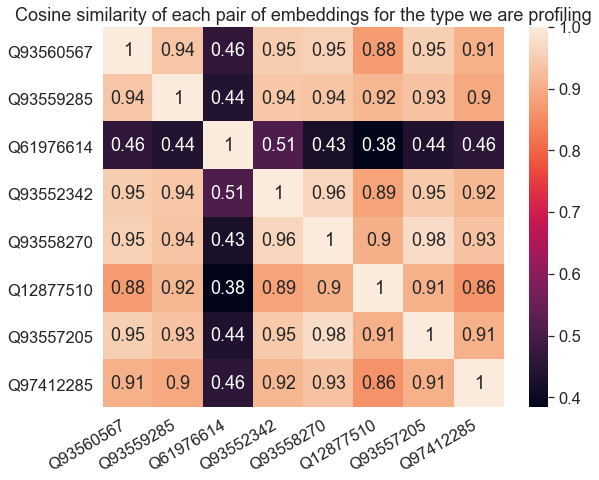

In [405]:
embeddings = entity_embeddings[all_ents_in_type]
similarity_mat = [entity_embeddings.cosine_similarities(e, embeddings) for e in embeddings]
mask = np.zeros_like(similarity_mat)
mask[np.triu_indices_from(mask)] = True
labels = all_ents_in_type
# Could mask to only show the lower triangle, but I think this is actually easier to read without the mask
fig, ax = plt.subplots(figsize=(9,7))
sns.set(font_scale=1.5)
sns.heatmap(similarity_mat, ax=ax, xticklabels=labels, yticklabels=labels, annot=True)
plt.xticks(rotation=30, horizontalalignment='right')
plt.title("Cosine similarity of each pair of embeddings for the type we are profiling")
plt.show()

From the visual above, it makes sense that the most distinctive label groups together all entities except Q61976614.

## 5. Iteratively choose labels to add to label set using formula
Fill in formula here

Functions for computing reward and penalty

Iteratively choose labels